In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

import json
import gzip
import pickle
import datetime

from collections import defaultdict
from scipy.spatial.distance import hamming
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
dataset_list = ['yeast', 'woman'] #, 'diabete']
blackbox_list = ['rf', 'svm', 'mlp']

In [3]:
hit_gdt = defaultdict(lambda: defaultdict(list))
rules_gdt = defaultdict(lambda: defaultdict(list))
gdt_labels = defaultdict(lambda: defaultdict(list))

for dataset in dataset_list:
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list:
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/GDT_to_mimic_%s_%s_metrics.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            #saving hit
            hit_gdt[dataset_name][bb_name].append(1.0 - r['hit_sm'])
            #saving rule lenght
            rules_gdt[dataset_name][bb_name].append(r['len_rule'])
            #saving label
            gdt_labels[dataset][bb_name].append(r['i2e_GDT_label'])
            
        resfile.close()

2018-11-03 16:43:35.807100 dataset: yeast
2018-11-03 16:43:35.808405 blackbox: rf
2018-11-03 16:43:35.887671 blackbox: svm
2018-11-03 16:43:35.965826 blackbox: mlp
2018-11-03 16:43:36.047229 dataset: woman
2018-11-03 16:43:36.047610 blackbox: rf
2018-11-03 16:43:36.512697 blackbox: svm
2018-11-03 16:43:36.990092 blackbox: mlp


### Comparison between mixed and union approaches

In [4]:
output_files = []
names_output = listdir('../output/')
for name in names_output:
    if name.startswith('20181103'):
        output_files.append(name)
output_files

['20181103_0226_yeast_rf_explanationsandmetrics.json.gz',
 '20181103_0228_woman_rf_explanationsandmetrics.json.gz',
 '20181103_0228_woman_svm_explanationsandmetrics.json.gz',
 '20181103_0226_yeast_svm_explanationsandmetrics.json.gz',
 '20181103_0227_yeast_mlp_explanationsandmetrics.json.gz',
 '20181103_0229_woman_mlp_explanationsandmetrics.json.gz']

In [5]:
mixed_fidelity_sn = defaultdict(list)
mixed_fidelity_rn = defaultdict(list)
union_fidelity_sn = defaultdict(list)
union_fidelity_rn = defaultdict(list)

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']

            mixed_fidelity_sn[bb_name].append(r['fidelity_tree1_syn'])
            mixed_fidelity_rn[bb_name].append(r['fidelity_tree1_kNN'])

            union_fidelity_sn[bb_name].append(r['fidelity_tree2_syn'])
            union_fidelity_rn[bb_name].append(r['fidelity_tree2_kNN'])

        resfile.close()

2018-11-03 16:43:39.125116 dataset: yeast
2018-11-03 16:43:39.130369 blackbox: rf
2018-11-03 16:43:39.197159 blackbox: svm
2018-11-03 16:43:39.267444 blackbox: mlp
2018-11-03 16:43:39.326655 dataset: woman
2018-11-03 16:43:39.326775 blackbox: rf
2018-11-03 16:43:39.642382 blackbox: svm
2018-11-03 16:43:39.969938 blackbox: mlp


In [6]:
print('Table 2')
for bb_name in blackbox_list:
    print(bb_name)
    print('\tmixed fidelity sn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_sn[bb_name]), np.std(mixed_fidelity_sn[bb_name])))
    print('\tunion fidelity sn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_sn[bb_name]), np.std(union_fidelity_sn[bb_name])))
    print('---')
    print('\tmixed fidelity rn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_rn[bb_name]), np.std(mixed_fidelity_rn[bb_name])))
    print('\tunion fidelity rn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_rn[bb_name]), np.std(union_fidelity_rn[bb_name])))

Table 2
rf
	mixed fidelity sn: 0.939 \pm 0.022
	union fidelity sn: 0.903 \pm 0.048
---
	mixed fidelity rn: 0.888 \pm 0.089
	union fidelity rn: 0.870 \pm 0.112
svm
	mixed fidelity sn: 0.908 \pm 0.047
	union fidelity sn: 0.878 \pm 0.060
---
	mixed fidelity rn: 0.598 \pm 0.211
	union fidelity rn: 0.612 \pm 0.233
mlp
	mixed fidelity sn: 0.945 \pm 0.034
	union fidelity sn: 0.937 \pm 0.046
---
	mixed fidelity rn: 0.629 \pm 0.261
	union fidelity rn: 0.632 \pm 0.243


## Hit performances MARLENA vs GDT

In [7]:
#saving hit values for MARLENA (both mixed and union)
hit_mixed = defaultdict(lambda: defaultdict(list))
hit_union = defaultdict(lambda: defaultdict(list))

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']

            hit_mixed[dataset_name][bb_name].append(1.0 - r['hit_sm_tree1'])
            hit_union[dataset_name][bb_name].append(1.0 - r['hit_sm_tree2'])

        resfile.close()

2018-11-03 16:43:49.803073 dataset: yeast
2018-11-03 16:43:49.804026 blackbox: rf
2018-11-03 16:43:49.868084 blackbox: svm
2018-11-03 16:43:49.929774 blackbox: mlp
2018-11-03 16:43:49.991928 dataset: woman
2018-11-03 16:43:49.992054 blackbox: rf
2018-11-03 16:43:50.297120 blackbox: svm
2018-11-03 16:43:50.633653 blackbox: mlp


Table 3 e plot-MIXED
yeast
	 rf
		hit MARLENA 0.973 pm 0.047
		hit GDT 0.982 pm 0.037
	 svm
		hit MARLENA 0.947 pm 0.065
		hit GDT 0.932 pm 0.067
	 mlp
		hit MARLENA 0.967 pm 0.051
		hit GDT 0.942 pm 0.066
woman
	 rf
		hit MARLENA 0.950 pm 0.066
		hit GDT 0.985 pm 0.036
	 svm
		hit MARLENA 0.864 pm 0.092
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.804 pm 0.147
		hit GDT 0.988 pm 0.034


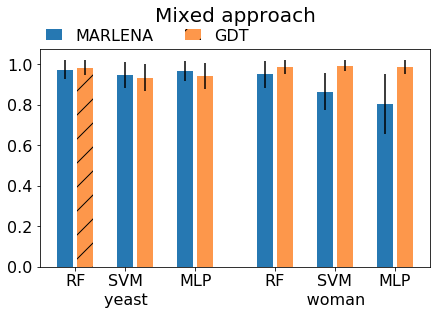

In [8]:
print('Table 3 e plot-MIXED')

plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_mixed[dataset_name][bb_name]), np.std(hit_mixed[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]), 
                    yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]), 
                    yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Mixed approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/MIXED_barplot.png', format='png', bbox_inches='tight')
plt.show()

Table 3 e plot-UNION
yeast
	 rf
		hit MARLENA 0.969 pm 0.048
		hit GDT 0.982 pm 0.037
	 svm
		hit MARLENA 0.946 pm 0.062
		hit GDT 0.932 pm 0.067
	 mlp
		hit MARLENA 0.966 pm 0.051
		hit GDT 0.942 pm 0.066
woman
	 rf
		hit MARLENA 0.942 pm 0.067
		hit GDT 0.985 pm 0.036
	 svm
		hit MARLENA 0.868 pm 0.093
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.797 pm 0.124
		hit GDT 0.988 pm 0.034


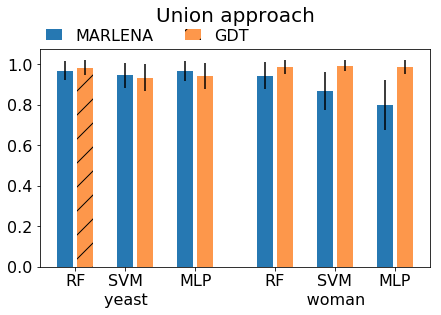

In [9]:
print('Table 3 e plot-UNION')

plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_union[dataset_name][bb_name]), np.std(hit_union[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_union[dataset_name][bb_name]), 
                    yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit_union[dataset_name][bb_name]), 
                    yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Union approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/UNION_barplot.png', format='png', bbox_inches='tight')
plt.show()

## Fidelities performances on interesting classes: MARLENA vs GDT

In [10]:
bb_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_labels = defaultdict(lambda: defaultdict(list))
union_marlena_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_rule_lenght = defaultdict(lambda: defaultdict(list))
union_marlena_rule_lenght = defaultdict(lambda: defaultdict(list))


for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        file_name = [output for output in output_files if dataset in output and bb_name in output][0]
        resfile = gzip.open('../output/'+file_name, 'rb')
        
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            bb_labels[dataset_name][bb_name].append(r['i2e_bb_label'])
            mixed_marlena_labels[dataset_name][bb_name].append(r['i2e_tree1_label']) 
            union_marlena_labels[dataset_name][bb_name].append(r['i2e_tree2_label']) 
            mixed_marlena_rule_lenght[dataset_name][bb_name].append(r['lenght_rule_tree1'])
            union_marlena_rule_lenght[dataset_name][bb_name].append(r['lenght_rule_tree2'])
        resfile.close()

2018-11-03 16:43:58.788995 dataset: yeast
2018-11-03 16:43:58.790442 blackbox: rf
2018-11-03 16:43:58.862444 blackbox: svm
2018-11-03 16:43:58.925971 blackbox: mlp
2018-11-03 16:43:58.985769 dataset: woman
2018-11-03 16:43:58.985898 blackbox: rf
2018-11-03 16:43:59.287322 blackbox: svm
2018-11-03 16:43:59.618144 blackbox: mlp


In [11]:
print('Table 4 - MIXED')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(mixed_marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            #qui faccio solo la media e la deviazione standard per le features che sono interessanti,
            #ovvero quelle che non sono tutte 0 o tutte 1 
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4 - MIXED
yeast
	 rf
MARLENA: avg 0.489, std 0.399, median 0.735
GDT:	 avg 0.778, std 0.278, median 0.860
	 svm
MARLENA: avg 0.621, std 0.348, median 0.756
GDT:	 avg 0.553, std 0.358, median 0.696
	 mlp
MARLENA: avg 0.885, std 0.078, median 0.887
GDT:	 avg 0.780, std 0.153, median 0.767

woman
	 rf
MARLENA: avg 0.411, std 0.388, median 0.492
GDT:	 avg 0.657, std 0.378, median 0.829
	 svm
MARLENA: avg 0.191, std 0.288, median 0.051
GDT:	 avg 0.883, std 0.125, median 0.927
	 mlp
MARLENA: avg 0.260, std 0.320, median 0.026
GDT:	 avg 0.620, std 0.373, median 0.732



/home/user/venvs/LORE_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/venvs/LORE_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [12]:
print('Table 4 - UNION')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(union_marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4 - UNION
yeast
	 rf
MARLENA: avg 0.505, std 0.369, median 0.689
GDT:	 avg 0.778, std 0.278, median 0.860
	 svm
MARLENA: avg 0.617, std 0.344, median 0.770
GDT:	 avg 0.553, std 0.358, median 0.696
	 mlp
MARLENA: avg 0.885, std 0.075, median 0.881
GDT:	 avg 0.780, std 0.153, median 0.767

woman
	 rf
MARLENA: avg 0.379, std 0.379, median 0.369
GDT:	 avg 0.657, std 0.378, median 0.829
	 svm
MARLENA: avg 0.185, std 0.287, median 0.066
GDT:	 avg 0.883, std 0.125, median 0.927
	 mlp
MARLENA: avg 0.260, std 0.330, median 0.020
GDT:	 avg 0.620, std 0.373, median 0.732



# Measures of rule lenght for the GDT

In [13]:
for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        
        print('\t', bb_name)
        mixed_mr = np.asarray(mixed_marlena_rule_lenght[dataset][bb_name])
        union_mr = np.asarray(union_marlena_rule_lenght[dataset][bb_name])
        gdt_mr = np.asarray(list(map(int, rules_gdt[dataset][bb_name])))
        
        print('MARLENA: mixed mean rule lenght\t %.2f pm %.2f' % (np.mean(mixed_mr),np.std(mixed_mr)))
        print('MARLENA: union mean rule lenght\t %.2f pm %.2f' % (np.mean(union_mr),np.std(union_mr)))
        print('GDT: mean rule lenght\t\t %.2f pm %.2f' % (np.mean(gdt_mr),np.std(gdt_mr)))

    print('')

yeast
	 rf
MARLENA: mixed mean rule lenght	 2.88 pm 2.37
MARLENA: union mean rule lenght	 2.84 pm 2.15
GDT: mean rule lenght		 9.09 pm 3.35
	 svm
MARLENA: mixed mean rule lenght	 3.32 pm 2.31
MARLENA: union mean rule lenght	 3.21 pm 2.03
GDT: mean rule lenght		 5.68 pm 1.47
	 mlp
MARLENA: mixed mean rule lenght	 2.48 pm 2.06
MARLENA: union mean rule lenght	 2.69 pm 2.28
GDT: mean rule lenght		 6.70 pm 2.36

woman
	 rf
MARLENA: mixed mean rule lenght	 4.30 pm 0.97
MARLENA: union mean rule lenght	 4.35 pm 1.19
GDT: mean rule lenght		 13.20 pm 4.56
	 svm
MARLENA: mixed mean rule lenght	 4.32 pm 1.52
MARLENA: union mean rule lenght	 4.37 pm 1.61
GDT: mean rule lenght		 16.30 pm 6.61
	 mlp
MARLENA: mixed mean rule lenght	 2.93 pm 1.18
MARLENA: union mean rule lenght	 2.76 pm 1.42
GDT: mean rule lenght		 14.85 pm 6.17

